In [1]:
from xml.dom import minidom
import re
import pandas as pd
import sys
import pickle
import numpy as np
import time
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
ps = PorterStemmer()
sys.__stdout__=sys.stdout

### Preprocessing steps

1. Stem regular verbs
2. Stem irregular verbs
3. Removing minor words
4. Removing tags and garbage charecters with rtegular expression.

*All of these is implemented with raw python (without nltk)

In [2]:
def stem_regular_verb(word):
    if len(word)<=3:
        return word
    if word[-2:]=='es':
        if word[:-2] in verbs:
            word=word[:-2]

    elif word[-1:]=='s':
        if word[:-1] in verbs:
            word=word[:-1]
            
    elif word[-3:]=='ing':
        if word[:-3] in verbs:
            word=word[:-3]
        if word[:-4] in verbs:
            word=word[:-4]
        else:
            word=word[:-3]
    
    elif word[-2:]=='ed':
        if word[:-2] in verbs:
            word=word[:-2]
        elif word[:-1] in verbs:
            word=word[:-1]
    #word=stem_irregular(word)
    return word
def stem_simple(word):
    if word[-2:]=='es':
            word=word[:-2]   
    elif word[-1:]=='s':
            word=word[:-1]
    elif word[-3:]=='ing':
            word=word[:-3]
    
    elif word[-2:]=='ed':
            word=word[:-2]
    return word

def stem_irregular_verb(word):
        if word in past:
            ind=past.index(word)
            word=verb_root[ind]
        elif word in past_pp:
            ind=past_pp.index(word)
            word=verb_root[ind]
        return word
def remove_minor_words(wordmap,word_count,min_occurance):
    words=list(wordmap.keys())
    freq=list(wordmap.values())
    word_df=pd.DataFrame(words,index=list(wordmap.values()),columns=['words'])
    word_df=word_df.sort_index()
    word_df['freq']=wc
    word_df=word_df.sort_values('freq',ascending=False)
    mask=word_df['freq']<=min_occurance
    word_df=word_df[mask]
    ss_words=(list(word_df['words']))
    print('initial length of wordmap :',len(wordmap))
    for word in ss_words:
        del wordmap[word]
    _wordmap={}
    ind=0
    for word in wordmap.keys():
        _wordmap[word]=ind
        ind+=1
    print('reduced length of wordmap :',len(_wordmap))
    return _wordmap

def stem_word(word):
    temp=word
    word=stem_regular_verb(word)
    word=stem_irregular_verb(word)
    #word=ps.stem(word)
    if(len(word)<=1):
        return temp
    return word   
def remove_tags(doc):
    text=doc.lower()
    #text=re.sub('\n',' ',text)
    #text=re.sub('-',' ',text)
    #text=re.sub('[()?.@*#&!,$]','',text)
    #text=re.sub('[\']','',text)
    #text=re.sub('[^a-z0-9]',' ',text)
    #words=text.split(' ')
    text=re.sub('<[^<>]+>',' ',text)
    #text=re.sub('^\w+',' ',text)
    #words=text.split('\n')
    words=re.findall('\w+',text)
    return words
def pre_process(topics,max_doc,root):
    index=0
    labels=[]
    ln=0
    labeled_docs={}
    for topic in topics:
        print(topic)
        mydoc = minidom.parse(root+topic+'.xml')
        documents = mydoc.getElementsByTagName('row')
        doc_count=0
        docs=[]
        for doc in documents:
            doc=doc.attributes['Body'].value
            if len(doc)<5:
                continue
            words = remove_tags(doc)
            ln+=len(words)
            docs.append(words)
            labels.append(topic)
            doc_count+=1
            if doc_count>=max_doc:
                break
        labeled_docs[topic]=docs
    return labeled_docs,ln

In [3]:
root='Dataset/reuters/Training/'
root_test='Dataset/Test/'

f=open('Dataset/Stopwords.txt')
s_words=f.read()
s_words=s_words.split('\n')
s_words.append('')

f=open('Dataset/verbs.txt','r')
verbs=f.read()
f.close()
verbs=verbs.split('\n')

irr=pd.read_csv('Dataset/irr_verbs.txt',delimiter=',',names=['root','past','past_par'])
verb_root=list(irr['root'])
past=list(irr['past'])
past_pp=list(irr['past_par'])

#topics=['3d_Printer','Coffee','Arduino','Astronomy','Biology']#,'Chess','Cooking','Law','Space','Windows_Phone','Wood_Working']
topics1=['3d_Printer','Anime','Arduino']#----------Tes topic set 1
topics2=['3d_Printer','Coffee','Chess']#-----------Topic set 2
topics3=['3d_Printer','Coffee','Chess','Astronomy','Law']#----------Topic set 3
#topics=['Arduino','Anime','Windows_Phone']
max_docs_train=600
max_docs_test=60
rm_minor_words=False
log=False
topics=topics2
root='Dataset/Training/'
train_docs,ln=pre_process(topics,max_docs_train,root)
test_docs,ln=pre_process(topics,max_docs_test,root_test)
print(ln)


3d_Printer
Coffee
Chess
3d_Printer
Coffee
Chess
26024


### Word to Vector
1. Creating dictionary of words from dataset
    
       Function make dictionary
    
2. Creating Vector for every Sample i.e
    
       Function Vectorize sequence
    
    if Sample -- > A
    
              Vector A -- > prob_of_word1,prob_of_word2, prob_of_word3 ...... prob_of_wordn
    
    if Sample -- > B
       
              Vector B -- > prob_of_word1,prob_of_word2, prob_of_word3 ...... prob_of_wordn

In [4]:
def make_dictionary(topics,max_doc,all_docs):
    index=0
    wordmap={}
    word_count=[]
    for topic in topics:
        print(topic)
        doc_count=0
        docs=all_docs[topic]
        for doc in docs:
            for word in doc:
                if word in s_words or len(word)<=1:
                    continue
                word=stem_word(word)
                if word not in wordmap:
                    wordmap[word]=index
                    word_count.append(int(1))
                    index=index+1
                elif word in wordmap:
                    ind=wordmap[word]
                    word_count[ind]=int(word_count[ind])+1
    return wordmap,word_count
def vectorize_seq(topics,max_doc,wordmap,all_docs):
    n_row=len(topics)*(max_doc)
    vectors=np.zeros((n_row,len(wordmap)),dtype=np.float64)
    vct_label=[]
    row=0
    for topic in topics:
        print(topic)
        doc_count=0
        docs=all_docs[topic]
        for doc in docs:
            #if len(doc)<5:
            #    continue
            for word in doc:
                word=stem_word(word)
                if word in wordmap:
                    ind=wordmap[word]
                    vectors[row,ind]=vectors[row,ind]+1
            row=row+1
            vct_label.append(topic)
            word_list.append(doc)
    return vectors,vct_label


In [5]:
def eucl_dis(test_vect,vectors,vct_labels):
    h_dists=[]
    for row in range(len(vct_labels)):
        vect=vectors[row]
        dist=np.abs(vect-test_vect)
        dist=np.square(dist)
        dist=np.sum(dist)
        dist=np.sqrt(dist)
        label=vct_labels[row]
        h_dists.append([dist,label])
    return h_dists
def humm_dis(test_vector,vectors,vct_labels):
    h_dists=[]
    
    test_vect=np.array(test_vector>0,dtype=np.float64)
    vects=np.array(vectors>0,dtype=np.float64)
    #test_vect=test_vector
    #vects=vectors
    for row in range(len(vct_labels)):
        vect=vects[row]
        label=vct_labels[row]
        dist=np.abs(vect-test_vect)
        #dist=dist*[test_vect!=0]
        dist=np.sum(dist)
        h_dists.append([dist,label])
    return h_dists
def cos_dis(test_vect,vectors,vct_labels):
    h_dists=[]
    
    vectors_bin= np.array(vectors>0,dtype=np.float64)
    wc_vect=np.sum(vectors_bin,axis=0)
    no_docs=len(vectors)
    
    IDF=no_docs/(wc_vect+1)
    IDF=np.log(IDF)
    
    for row in range(len(vct_labels)):
        train_vect=vectors[row]
        
        train_label=vct_labels[row]
        
        train_total=np.sum(train_vect)
        test_total=np.sum(test_vect)
        
        TF_test=test_vect/test_total
        test_vec=TF_test*IDF
        
        temp=np.square(test_vec)
        temp=np.sum(temp)
        test_vec_mag=np.sqrt(temp)
        
        TF_train=train_vect/train_total
        train_vec=TF_train*IDF
        
        temp=np.square(train_vec)
        temp=np.sum(temp)
        train_vec_mag=np.sqrt(temp)
        
        X=np.sum(test_vec*train_vec)
        Y=train_vec_mag*test_vec_mag
        
        dist=X/Y
        h_dists.append([dist,train_label])
    return h_dists

In [6]:
def knn(nn,test_vect,vectors,vct_labels,method):
    if method=='euc':
        h_dists=eucl_dis(test_vect,vectors,vct_labels)
    if method=='hum':
        h_dists=humm_dis(test_vect,vectors,vct_labels)
    if method=='cos':
        h_dists=cos_dis(test_vect,vectors,vct_labels)
    h_df=pd.DataFrame(h_dists,columns=['dist','label'])
    
    if method=='euc' or method=='hum':
        h_df=h_df.sort_values('dist',ascending=True)
    if method=='cos':
        h_df=h_df.sort_values('dist',ascending=False)
    #print(h_df.head(5))
    lb=h_df['label']
    lb=lb[:nn]
    #print(lb.values)
    
    if k==1:
        lb=lb.mode()
        lb=lb.values[0]
        
    if k==3:
        if len(lb.unique())==k:
            lb=lb[:1]
        lb=lb.mode()
        lb=lb.values[0]
    if k==5:
        if len(lb.mode())>=2:
            lb=lb[:3]
            if len(lb.mode())>=2:
                lb=lb[:1]
        lb=lb.mode()
        lb=lb.values[0]
        
                        
    return lb

In [7]:
word_list=[]
min_occurance=1
print('Making dictionary :')
wordmap,wc=make_dictionary(topics,max_docs_train,train_docs)
if rm_minor_words==True:
    print('Removing minor words:')
    wordmap=remove_minor_words(wordmap,wc,min_occurance)
print('Vectorizing Sequence:')
vectors,vct_labels=vectorize_seq(topics,max_docs_train,wordmap,train_docs)
print(len(wordmap))

Making dictionary :
3d_Printer
Coffee
Chess
Vectorizing Sequence:
3d_Printer
Coffee
Chess
11904


In [8]:
from tqdm import tqdm
test_vector,true_lbs=vectorize_seq(topics,max_docs_test,wordmap,test_docs)
n=len(topics)*max_docs_test
methods=['cos','euc','hum']
k_val=[1,3,5]
#k_val=[5]
no_topics=len(topics)
tot_doc=no_topics*max_docs_train
tot_doc_test=no_topics*max_docs_test

acc_log=''
acc_log+='********************************************************************************************\n'
acc_log+=str(topics)+'\n'
acc_log+='stem : none , re : findall , minor_remove: 1\n'
acc_log+=str(['no_topic','train doc per topic','train_doc','test doc per topic','test_doc','word map'])+'\n'
acc_log+=str([no_topics,max_docs_train,tot_doc,max_docs_test,tot_doc_test,str(len(wordmap))])+'\n'
acc_log+='********************************************************************************************\n'
acc_log+=str(['k','method','accuracy','time'])+'\n'
for k in k_val:
    for method in methods:
        acc=0
        T=time.time()
        for i in tqdm(range(len(test_vector))):
            true_lb=true_lbs[i]
            test_vect=test_vector[i,:]
            pred_lb=knn(k,test_vect,vectors,vct_labels,method)
            #print(pred_lb,true_lb)
            if pred_lb==true_lb:
                acc=acc+1
                #print(pred_lb,true_lb,acc,i+1)
        accuracy=acc/(n)
        T=time.time()-T
        #print('accuray',accuracy)
        #print('Time :',T)
        acc_log+=(str([k,method,accuracy,T])+'\n')

acc_log=re.sub('[\[\] ]','',acc_log)
if log==True:
    file=open('Report/backup_exp_mod.txt','a')
    file.write(acc_log)
    file.close()
    pass

#68.75% eucl 60 82.92
#53.33 humm 60  81.25
#87.08 cos 94.17

3d_Printer
Coffee
Chess


100%|██████████| 180/180 [00:24<00:00,  7.48it/s]


In [9]:
import pandas as pd
_result_log=pd.DataFrame(data={},columns=['true','pred','right','wrong'])

for i in range(len(test_vector)):
        test_vect=test_vector[i,:]
        pred_label=knn(k,test_vect,vectors,vct_labels,method='cos')
        _result_log.loc[i,'true']=true_lbs[i]
        _result_log.loc[i,'pred']=pred_label
        
        if pred_label==true_lbs[i]:
            acc=acc+1
            _result_log.loc[i,'right']=1
            _result_log.loc[i,'wrong']=0
        else :
            _result_log.loc[i,'right']=0
            _result_log.loc[i,'wrong']=1
        
       

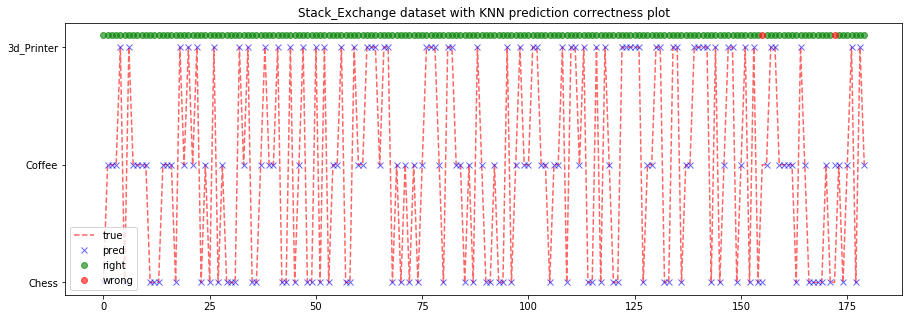

In [16]:
from matplotlib import pyplot as plt
#plt.plot(result_log[['right','wrong']])
result_log=_result_log.sample(frac=1).reset_index()
dataset = 'Stack_Exchange'
fig=plt.figure(figsize=(15,5))
plt.plot(result_log.loc[:,'true'],'r--',alpha=0.6)
plt.plot(result_log.loc[:,'pred'],'bx',alpha=0.6)
plt.plot(result_log.loc[:,'right'][result_log.loc[:,'right']==1]+1.1,'go',alpha=0.6)
plt.plot(result_log.loc[:,'right'][result_log.loc[:,'right']==0]+2.1,'ro',alpha=0.6)
#plt.plot(result_log.loc[:100,'right'],'go',alpha=0.3)
plt.legend(['true','pred','right','wrong'])
plt.title(dataset+' dataset with KNN prediction correctness plot')# \n right : 1 \n wrong : 0')
plt.savefig(dataset+'_KNN_pred.jpg')
plt.show()

----------------------
label 3d_Printer
precision 0.967741935483871
recall 1.0
----------------------
----------------------
label Chess
precision 0.9833333333333333
recall 0.9833333333333333
----------------------
----------------------
label Coffee
precision 0.9833333333333333
recall 0.9833333333333333
----------------------
Over All Accuracy :  0.9888888888888889


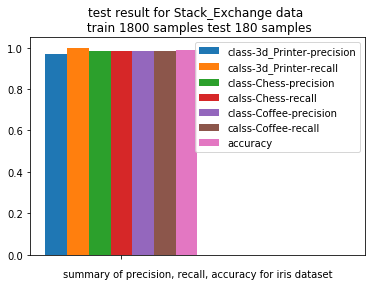

In [11]:
total=len(result_log)
acc=result_log.right.sum()#,len(result_log)
accuracy=acc/total
labels=result_log['true'].unique()
ldf=pd.DataFrame(data={},index=[' '])
precisions={}
recalls={}
for label in labels:
    true_ind=result_log['true']==label
    false_ind=result_log['true']!=label
    Yes=result_log.loc[true_ind]
    No=result_log.loc[false_ind]
    tp=Yes.right.sum()
    tn=Yes.wrong.sum()
    fn=No.right.sum()
    fp=No.wrong.sum()
    recall=tp/(tp+tn)
    precision=tp/(tp+fp)
    precisions[label]=precision
    recalls[label]=recall
    print('----------------------')
    print('label',label)
    print('precision',precision)
    print('recall',recall)
    print('----------------------')
print('Over All Accuracy : ',accuracy)

df=pd.DataFrame({},index=[' '])
#fig=plt.figure(figsize=(10,10))
for label in result_log['true'].unique():
    df['class-'+str(label)+'-precision']=[precisions[label],]
    df['calss-'+str(label)+'-recall']=[recalls[label],]
df['accuracy']=accuracy 
df.plot.bar()
plt.xlim(-.3,.8)
plt.title('test result for ' +dataset+ ' data \n '+'train '+str(len(vectors))+' samples test '+str(len(result_log))+' samples')
plt.xlabel('summary of precision, recall, accuracy for iris dataset')
plt.savefig(dataset+'_KNN.png')
plt.show()

In [12]:
print(acc_log)

********************************************************************************************
'3d_Printer','Coffee','Chess'
stem:none,re:findall,minor_remove:1
'no_topic','traindocpertopic','train_doc','testdocpertopic','test_doc','wordmap'
3,600,1800,60,180,'11904'
********************************************************************************************
'k','method','accuracy','time'
1,'cos',0.9666666666666667,52.566368103027344
1,'euc',0.8555555555555555,9.76721978187561
1,'hum',0.8055555555555556,24.702521085739136
3,'cos',0.9888888888888889,54.286924839019775
3,'euc',0.85,10.32445502281189
3,'hum',0.7611111111111111,25.483862161636353
5,'cos',0.9888888888888889,50.766660928726196
5,'euc',0.8277777777777777,9.470400094985962
5,'hum',0.7111111111111111,24.196748971939087



### Extra Debugs

In [13]:
st='i am hasib 3dprinter 4kjl <p> </pl>'
st=re.sub('<[^<>]+>',' ',st)
s=re.findall('\w+',st)
print(s)

['i', 'am', 'hasib', '3dprinter', '4kjl']


In [14]:
file=open('Report/backup_exp_mod.txt','a')
file.write(acc_log)
file.close()
print(acc_log)

********************************************************************************************
'3d_Printer','Coffee','Chess'
stem:none,re:findall,minor_remove:1
'no_topic','traindocpertopic','train_doc','testdocpertopic','test_doc','wordmap'
3,600,1800,60,180,'11904'
********************************************************************************************
'k','method','accuracy','time'
1,'cos',0.9666666666666667,52.566368103027344
1,'euc',0.8555555555555555,9.76721978187561
1,'hum',0.8055555555555556,24.702521085739136
3,'cos',0.9888888888888889,54.286924839019775
3,'euc',0.85,10.32445502281189
3,'hum',0.7611111111111111,25.483862161636353
5,'cos',0.9888888888888889,50.766660928726196
5,'euc',0.8277777777777777,9.470400094985962
5,'hum',0.7111111111111111,24.196748971939087



In [15]:
raw='I am hasib\n,i "am" a student() so? @i do& my-duties! porp. and' 
#text=re.sub('\n',' ',raw)
text=raw.lower()
text=re.sub('[^a-z0-9]',' ',text)
#text=re.sub('-',' ',text)
#text=re.sub('[\'"]','',text)
#text=re.sub('[()?.@*#&!,$+]','',text)
#print(text.split(' '))